# Modeling
This notebook is where I trained different models and choose the best for filling in the missing values.  
  
It consists of the following parts:

1. Data Preparation
2. Selecting Parameters
3. Selecting the Model
4. Predicting Missing Values

### 1. Data Preparation
Here, I do some basic data wrangling to make sure that the data is loaded correctly, has the right types and the correct distribution for modeling. Most of the cleaning has been done in the 0. Cleaning Data notebook. 

In [85]:
import pandas as pd
import numpy as np
import matplotlib as plt
import json
import seaborn as sns
from copy import deepcopy

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [86]:
intraday = pd.read_csv('../Files/intraday.csv')
summaries = pd.read_csv('../Files/summaries.csv')
sleep = pd.read_csv('../Files/sleep.csv')

In [87]:
# Creating copy and doing some basic data resampling for easier visibility 
intraday_copy = intraday.copy()

intraday_copy['time'] = pd.DatetimeIndex(intraday_copy['time'])
intraday_copy.set_index('time', inplace=True)
intraday_copy = intraday_copy.resample('5T').ffill()
intraday_copy.reset_index(inplace=True)

intraday_copy.drop('time', inplace = True, axis = 1)
intraday_copy.drop(intraday_copy[np.isnan(intraday_copy['heartrate'])].index, axis = 0, inplace = True)

X = intraday_copy.iloc[:, list(range(len(intraday_copy.columns)-1))].values
y = intraday_copy.iloc[:, -1].values

# Heart Rate is not normally distributed so we take the logarithm + 1
y = np.log1p(y)

### 2. Grid Search - Selecting Parameters
Here I'm using several different models and parameters to see which are best for each model. 

In [7]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

def grid_search(param_grid, estimator):
    grid = GridSearchCV(estimator,param_grid,refit=True,verbose=3)
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    print(grid.best_estimator_)

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)


param_grid_gradient = {'n_estimators': [500, 3000], 
              'learning_rate': np.arange(0.01, 0.1, 0.01), 
              'max_depth': [1, 3, 5, 7], 
             'min_samples_leaf': [10, 15, 20],
             'min_samples_split': [10, 15, 20]}

param_grid_lasso = {'alpha':np.arange(0.0001, 0.001, 0.000001), 
                    'max_iter': [10000]}

param_grid_net = {'alpha': np.arange(0.0001, 0.001, 0.00001),
                 'max_iter': np.arange(1000, 10000, 1000)}

param_grid_ridge = {'alpha': np.arange(0.1, 0.9, 0.1), 
                    'kernel': ['polynomial'], 
                    'degree': np.arange(2, 3, 1), 
                    'coef0':[1.85]} 

param_grid_xgb = {'colsample_bytree' :[0.2],
                 'gamma': [0.0],
                 'learning_rate': [0.01, 0.05, 0.1],
                 'min_child_weight': [1.5],
                 'n_estimators': np.arange(5000, 30000, 5000),                                                          
                 'reg_alpha': [0.9],
                 'reg_lambda': [0.6],
                 'subsample': [0.2, 0.3],
                'max_depth': [1, 2, 3, 4]}

# grid_search(param_grid_xgb, XGBRegressor())
# grid_search(param_grid_gradient, GradientBoostingRegressor())
# grid_search(param_grid_lasso, Lasso())
# grid_search(param_grid_net, ElasticNet())
# grid_search(param_grid_ridge, KernelRidge())

### 3. Selecting the Model
I calculate the RMSE for each model using 10-fold cross validation. 

In [50]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [52]:
models = [RandomForestRegressor(n_estimators=100), 
    GradientBoostingRegressor(n_estimators=500, 
                                     learning_rate=0.05, 
                                     max_depth=3, 
                                     max_features='sqrt',
                                     min_samples_leaf=15, 
                                     min_samples_split=10, 
                                     loss='huber'),
    ElasticNet(alpha=0.0001, max_iter=1000),
    Lasso(alpha=0.0001, max_iter=10000),
    XGBRegressor(n_estimators = 3000, gamma = 0.0,  reg_lambda = 0.6,  min_child_weight = 1.5,
                  reg_alpha = 0.9, learning_rate = 0.01, max_depth = 4, subsample = 0.2, seed = 42, silent = 1)]

log_cols = ["Model", "RMSE"]
log = pd.DataFrame(columns=log_cols)

kfold = KFold(n_splits=10)
scores = {}

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for model in models:
        name = model.__class__.__name__ # Get name of the model
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = rmse(y_test, y_pred)
        
        if name in scores:
            scores[name] += score
        else:
            scores[name] = score
    
for model in scores:
    scores[model] = scores[model] / 10
    log_entry = pd.DataFrame([[model, scores[model]]], columns=log_cols)
    log = log.append(log_entry)

In [62]:
! pip install mlxtend

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

models = [RandomForestRegressor(n_estimators=100), 
    GradientBoostingRegressor(n_estimators=500, 
                                     learning_rate=0.05, 
                                     max_depth=3, 
                                     max_features='sqrt',
                                     min_samples_leaf=15, 
                                     min_samples_split=10, 
                                     loss='huber'),
    ElasticNet(alpha=0.0001, max_iter=1000),
    Lasso(alpha=0.0001, max_iter=10000),
    XGBRegressor(n_estimators = 3000, gamma = 0.0,  reg_lambda = 0.6,  min_child_weight = 1.5,
                  reg_alpha = 0.9, learning_rate = 0.01, max_depth = 4, subsample = 0.2, seed = 42, silent = 1)]

from mlxtend.regressor import StackingRegressor
stregr = StackingRegressor(regressors=[models[2], models[-1]], 
                           meta_regressor=models[1]).fit(X, y)

score =  rmse_cv(stregr).mean()


You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [63]:
log_entry = pd.DataFrame([['Stack', score]], columns=log_cols)
log = log.append(log_entry)

In [77]:
log['Choosen'] = 0

In [79]:
log['Choosen'][log['Model'] == 'GradientBoostingRegressor'] = 1

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


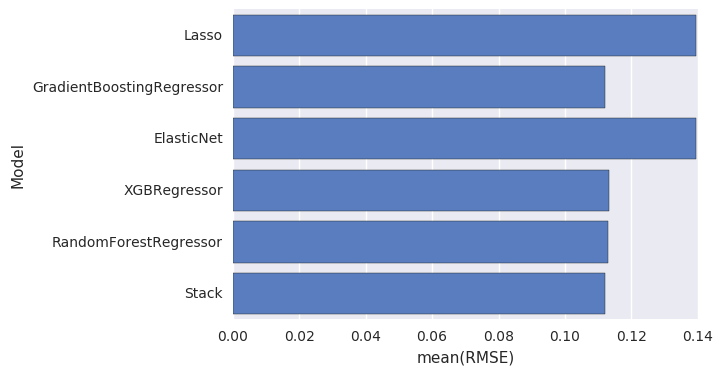

In [80]:
# plt.xlabel('Model')
# plt.title('Model RMSE')

sns.set_color_codes("muted")
sns.barplot(x='RMSE', y='Model', data=log, color="b")

/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Saving 9.72 x 6.94 in image

  warnings.warn(x, RRuntimeWarning)


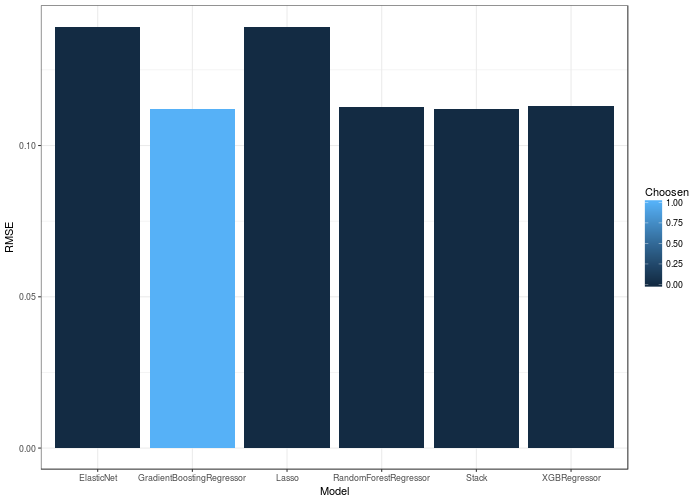

In [83]:
%%R -w 700 -h 500 -i log

plot <- ggplot(log, aes(y = RMSE, x = Model, fill = Choosen)) + 
    geom_col() +
    theme_bw()

ggsave("../Files/model.png")

plot

### 4. Predicting Missing Values

In [88]:
import datetime

# Creating copies of data to train and test on 
train_dataset = intraday.copy(deep = True)
test_dataset = intraday.copy(deep = True)

# Small things to make the data train and testable. 
train_dataset.dropna(inplace = True)

train_dataset['time'] = pd.DatetimeIndex(train_dataset['time'])
test_dataset['time'] = pd.DatetimeIndex(test_dataset['time'])

train_dataset.set_index('time', inplace = True)
test_dataset.set_index('time', inplace = True)

train_dataset = train_dataset.resample('5T').ffill()
test_dataset = test_dataset.resample('5T').ffill()

In [96]:
# Creating train data and the data on which to predict
X_train = train_dataset[(train_dataset.index.date == datetime.date(2017, 5, 3))][['floors', 'distance', 'calories', 'steps']]
y_train = train_dataset[(train_dataset.index.date == datetime.date(2017, 5, 3))]['heartrate']

day_to_predict = test_dataset[(test_dataset.index.date ==datetime.date(2017, 5, 9))][['floors', 'distance', 'calories', 'steps']]

In [97]:
# The parameters were found by using a grid search
model = GradientBoostingRegressor(n_estimators=3000, 
                                     learning_rate=0.05, 
                                     max_depth=3, 
                                     max_features='sqrt',
                                     min_samples_leaf=15, 
                                     min_samples_split=10, 
                                     loss='huber')


model.fit(X_train, y_train)
y_pred = model.predict(day_to_predict)

In [98]:
# Creating a dataframe that merges the prediction with the real values so I can plot a nice graph showing
# how it looks when the model predicts the missing values

plot_date = pd.DataFrame(test_dataset[(test_dataset.index.date == datetime.date(2017, 5, 9))]['heartrate'])
plot_date['prediction'] = y_pred

row_pos = np.arange(102, 143, 1)
dates = [plot_date.index[i] for i in row_pos]

plot_date['true'] = 0
plot_date['true'].ix[dates] = 1

plot_date['heartrate'][dates] = plot_date.prediction.ix[dates]
plot_date.reset_index(inplace = True)

# To turn of the annoying warning, however using .loc should resolve it I believe
plot_date.is_copy = False

/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**Showing and saving the prediction**

/opt/conda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Saving 12.5 x 9.72 in image

  warnings.warn(x, RRuntimeWarning)


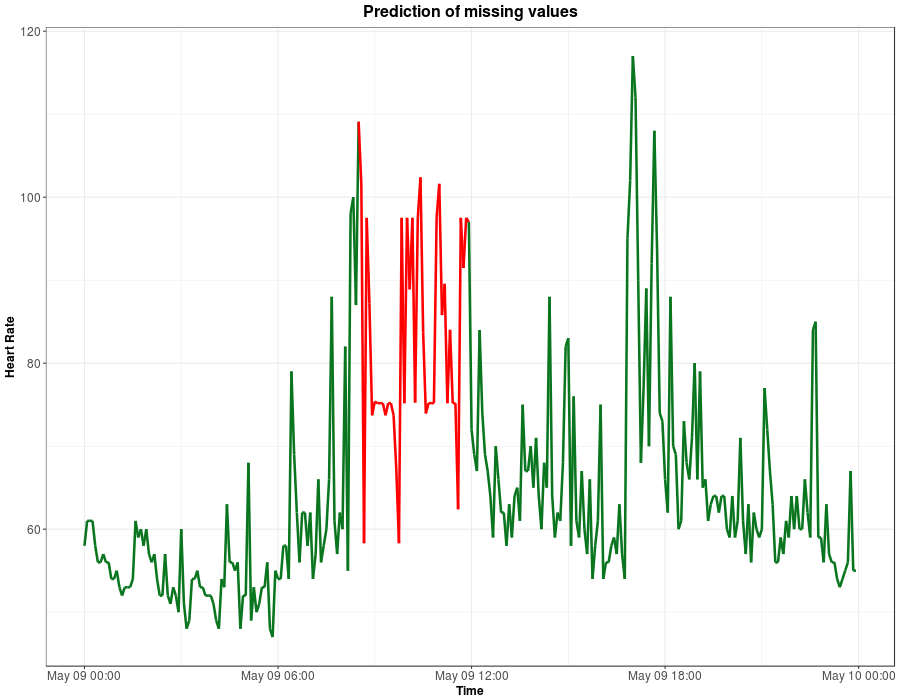

In [99]:
%%R -w 900 -h 700 -i plot_date
library(ggplot2)

cbPalette <- c("#0A751F", "#FF0000")

ggplot(plot_date, aes(x=time, y=heartrate, color = true)) + 
    geom_line(size = 1.2) +
    theme_bw() +
    labs( y = "Heart Rate", x = 'Time', title ="Prediction of missing values") +
    theme(legend.position="none", axis.text=element_text(size=12), axis.title=element_text(size=12,face="bold"),
         plot.title = element_text(lineheight=1, face="bold", size=16, , hjust = 0.5)) +
    scale_colour_gradientn(colours=cbPalette)

ggsave("../Files/missing values prediction.png")

ggplot(plot_date, aes(x=time, y=heartrate, color = true)) + 
    geom_line(size = 1.2) +
    theme_bw() +
    labs( y = "Heart Rate", x = 'Time', title ="Prediction of missing values") +
    theme(legend.position="none", axis.text=element_text(size=12), axis.title=element_text(size=12,face="bold"),
         plot.title = element_text(lineheight=1, face="bold", size=16, , hjust = 0.5)) +
    scale_colour_gradientn(colours=cbPalette)